# Figures 4 and S5: Human results
This script generates figures 4 and S5 of the paper, giving the results of our analysis on the human dataset using MCSPACE.

### Before you start
This notebook assumes the analysis on the human dataset have been run and results are located in `MCSPACE_paper/results/analysis/Human`. Refer to the README in `scripts/analysis` for the analysis pipeline and more details.

In [1]:
import numpy as np
import torch
from mcspace.model import MCSPACE
from mcspace.trainer import train_model
from mcspace.data_utils import get_data, get_mouse_diet_perturbations_dataset
from mcspace.utils import get_device, pickle_load, pickle_save,\
    estimate_process_variance, MODEL_FILE, DATA_FILE, \
    get_mcspace_cooccur_prob, get_sig_perturbation_diff_subset, \
    get_posterior_summary_data, get_pert_otu_sub, get_min_loss_path, apply_taxonomy_threshold, \
    get_summary_results, get_subj_averaged_assemblage_proportions
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from mcspace.dataset import DataSet
import pandas as pd

import ete3
from Bio import SeqIO, Phylo

import matplotlib.colors as mcolors
import mcspace.vis_tools as vis
import matplotlib.patches as mpatches

import scipy.cluster.hierarchy as sch

In [2]:
# change font to arial
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'

# Paths

Note: Paths are relative to this notebook, which is assumed to be located in `MCSPACE_paper/figures`

In [3]:
rootpath = Path("../../")
basepath = Path("./")
datapath = rootpath / "MCSPACE_paper" / "datasets"

treepath = datapath / "human_experiments" / "human_otus_tree" / "output"
treefile = "newick_tree_query_reads.nhx"

respath = rootpath / "MCSPACE_paper" / "results" / "analysis" / "Human"

In [4]:
outpath = basepath / "paper_figures" / "Human"
outpath.mkdir(exist_ok=True, parents=True)

# Load results

In [5]:
thetadf = pd.read_csv(respath / "assemblages.csv")
betadf = pd.read_csv(respath / "assemblage_proportions.csv", index_col=0)
radf= pd.read_csv(respath / "relative_abundances.csv", index_col=0)

In [6]:
taxlevels = ['Otu', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
taxonomy = thetadf[taxlevels].copy()
taxonomy = taxonomy.set_index("Otu")
thetadf = thetadf.set_index(taxlevels)
radf.columns = radf.columns.astype(int)
avebeta = get_subj_averaged_assemblage_proportions(betadf)

times = avebeta.index
subjects = ['H11']

# update taxonomic labels
taxonomy.loc['Otu17','Genus'] = 'Mediterraneibacter'
taxonomy.loc['Otu3','Genus'] = 'Phocaeicola'
taxonomy.loc['Otu3','Species'] = 'Phocaeicola dorei'
taxonomy.loc['Otu47','Genus'] = 'Eubacterium hallii'
taxonomy.loc['Otu44', 'Family'] = 'Oscillospiraceae'

taxonomy=taxonomy.rename(columns={'Kingdom':'Domain'})

# Get most and least variable assemblages

In [7]:
beta = avebeta.T
beta['T-max'] = beta.max(axis=1)
beta['Mean'] = beta.mean(axis=1)
beta['Variance'] = np.log(beta).var(axis=1)
beta = beta.T

### least variable

In [8]:
varthres = 0.1

persistent = beta.columns[beta.loc['Variance',:]<varthres]
print(persistent)

# also cluster columns...
theta_persistent = np.log10(thetadf.loc[:,persistent] + 1e-20).values

data_matrix=theta_persistent.T
row_dist = sch.linkage(data_matrix, method='ward')
persist_row_order = sch.leaves_list(row_dist)

persistent = persistent[persist_row_order]
print(persistent)

Index(['A13', 'A25', 'A26', 'A6'], dtype='object', name='Assemblage')
Index(['A25', 'A13', 'A26', 'A6'], dtype='object', name='Assemblage')


### most variable

In [9]:
nx = 3

sigchanged = []
for aidx in beta.columns:
    temp = beta.loc[:,aidx]
    for day in times:
        rest = np.array([j for j in times if j != day])
        maxother = np.amax(temp[rest].values)
        current = temp[day]
        if current >= maxother*nx:
            sigchanged.append(aidx)
        
sigchanged = pd.Index(sigchanged)

# cluster columns...
theta_var = np.log10(thetadf.loc[:,sigchanged] + 1e-20).values

data_matrix=theta_var.T
row_dist = sch.linkage(data_matrix, method='ward')
row_order = sch.leaves_list(row_dist)

sigchanged = sigchanged[row_order]
print(sigchanged)

Index(['A12', 'A31', 'A34'], dtype='object')


### filter by 5% abundance

In [10]:
otu_threshold = 0.05

betasub = list(set(persistent).union(set(sigchanged)))

otu_sub_5 = thetadf.index[(thetadf.loc[:,betasub]>otu_threshold).any(axis=1)].get_level_values('Otu')
notus = len(otu_sub_5)
print(notus)

12


# Plot figure 4

In [11]:
ncomm_max = 50
notu_max = 80

tree_ratio = 0.1
gap_ratio = 0.2

ntime = len(times)
nsubj = len(subjects)

npert = len(persistent)
nvar = len(sigchanged)
ncomm = npert + nvar

# theta_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","green"])
theta_vmin=-2
theta_vmax=0
theta_cmap = mcolors.LinearSegmentedColormap.from_list('theta cmap', 
                                             [(0,    'white'),
                                              (0.25, 'lightyellow'),
                                              (0.5, 'yellowgreen'),
                                              (1,    'green')], N=256)
linewidth = 0.5
linecolor = '#e6e6e6'

In [12]:
plotfams = taxonomy.loc[otu_sub_5,'Family'].unique()
colors = [sns.color_palette("colorblind")[i] for i in [0,1,3,5,6,7,8]]
familycolors = {x:y for x,y in zip(plotfams,colors)}

In [13]:
print(persistent)
print(sigchanged)

Index(['A25', 'A13', 'A26', 'A6'], dtype='object', name='Assemblage')
Index(['A12', 'A31', 'A34'], dtype='object')


In [15]:
# reorder assemblages by most/least changed
beta.loc[:,persistent].T.sort_values(by='Variance')

Time,1,2,3,4,5,T-max,Mean,Variance
Assemblage,,,,,,,,
A26,0.022988,0.018648,0.017690,0.017658,0.015656,0.022988,0.019271,0.020145
A25,0.026706,0.034877,0.019619,0.032965,0.037531,0.037531,0.031538,0.053745
A13,0.021145,0.025161,0.041738,0.022339,0.022156,0.041738,0.029046,0.086025
A6,0.039611,0.021742,0.027986,0.024518,0.045377,0.045377,0.034102,0.087791


In [16]:
sigchanged = pd.Index(['A34', 'A31', 'A12'])
persistent = pd.Index(['A26', 'A25', 'A13', 'A6'])

In [17]:

def get_pruned_tree(treepath, treefile, taxonomy, temppath=Path("./_tmp"), upper=False):
    tree = ete3.Tree((treepath / treefile).as_posix())
    print("original tree size:", len(tree))
    taxaids = list(taxonomy.index)
    if upper:
        taxaids = [idx.upper() for idx in taxaids]
    tree.prune(taxaids, True)
    print("pruned tree size:", len(tree))
    
    ancestor = tree.get_common_ancestor("OTU11","OTU3")
    tree.set_outgroup(ancestor)
    
    treeout = "tree.nhx"
    temppath.mkdir(exist_ok=True, parents=True)
    tree.write(outfile=(temppath / treeout).as_posix())
    phylo_tree = Phylo.read(temppath / treeout, format='newick')
    return phylo_tree



def plot_phylo_tree(ax, tree, taxonomy, fontsize=16, text_len=41):            
    TEXT_LEN=text_len
    prefix_taxa = {'Species': '*', 'Genus': '**', 'Family': '***', 'Order': '****',
                   'Class': '*****', 'Phylum': '******', 'Domain': '*******'}

    Phylo.draw(tree, axes=ax, do_show=False, show_confidence=False)
    taxa_order = []

    for text in ax.texts:
        taxonname = str(text._text).replace(' ','').capitalize()
        otu_name = taxonname
        taxa_order.append(otu_name)
        name, level = vis.get_lowest_level(otu_name, taxonomy)
        prefix = prefix_taxa[level]
        taxonname = ' ' + prefix + ' ' + name + ' ' + otu_name.upper()
        text._text = taxonname
        text._text = text._text + '- ' * (TEXT_LEN - len(text._text))
        text.set_fontsize(fontsize)
        if (level == 'Species') or (level == 'Genus'):
            text.set_fontstyle('italic')
    ax = vis.remove_border(ax)
    return ax, taxa_order

original tree size: 3923
pruned tree size: 12


C:\Users\Gary\anaconda3\envs\mcfinal\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
C:\Users\Gary\anaconda3\envs\mcfinal\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


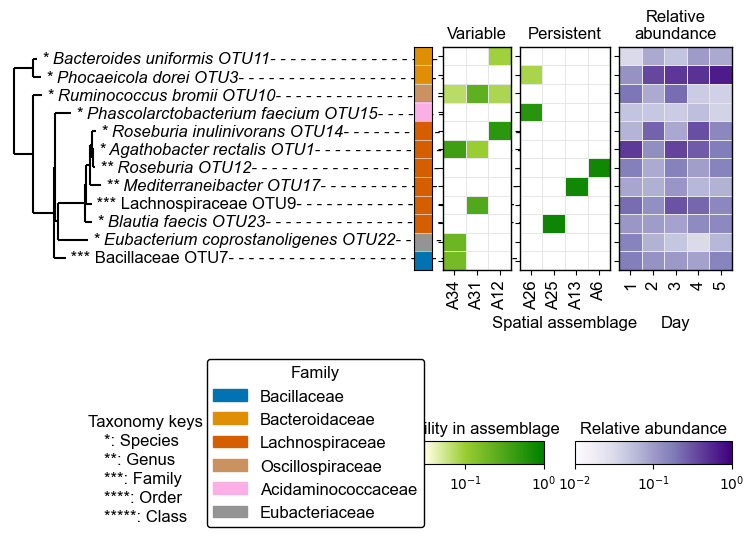

In [19]:
tree_ratio = 0.1
gap_ratio = 0.24

tree_text_len = 50
scale=2
tree_fontsize=12

# set aspect ratios
# add buffers so scales always same?
lgd_ratio = 0.05
lgd_gap = 0.1
hratios = [notus/notu_max, lgd_gap, lgd_ratio]
hratios.append(1.0 - (notus/notu_max)) # buffer?

# width ratios
wratios = [tree_ratio, gap_ratio, 1/ncomm_max,
#            npert/ncomm_max, nvar/ncomm_max, 
           nvar/ncomm_max, npert/ncomm_max, 
           ntime/ncomm_max,
           1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=4,ncols=6+1,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.05,
                     hspace=0.02)

# create subplots, get axes
ax_tree = fig.add_subplot(gs[0,0])

# squish to center lines...
squish_ratio = 0.01
squish_hspace = 0
gs_fam = gs[0,2].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_fam = fig.add_subplot(gs_fam[1,0])

gs_pert = gs[0,4].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_pert = fig.add_subplot(gs_pert[1,0])
gs_var = gs[0,3].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_var = fig.add_subplot(gs_var[1,0])

gs_ra = gs[0,5].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_ra = fig.add_subplot(gs_ra[1,0])


# # ax_sing = fig.add_subplot(gs[0,2])
# ax_fam = fig.add_subplot(gs[0,2])
# ax_pert = fig.add_subplot(gs[0,3])
# ax_var = fig.add_subplot(gs[0,4])
# ax_ra = fig.add_subplot(gs[0,5])

# for legend...
gs_lgd = gs[-2,:-1].subgridspec(3,4)
ax_taxa_lgd = fig.add_subplot(gs_lgd[:,0])
ax_theta_lgd = fig.add_subplot(gs_lgd[0,2])
ax_ra_lgd = fig.add_subplot(gs_lgd[0,3])
ax_fam_lgd = fig.add_subplot(gs_lgd[:,1])


# plot tree
taxa = taxonomy.reset_index().copy()
taxa = taxa.set_index("Otu")
taxa_subset = taxa.loc[otu_sub_5,:]
tree = get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"), upper=True)
ax_tree, otu_order = plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=tree_fontsize, text_len=tree_text_len)

# plot family annotation
ntaxa = len(otu_order)
pcolors = np.zeros((ntaxa,1,3))
for i,x in enumerate(taxonomy.loc[otu_order,'Family']):
    pcolors[i,0,:] = familycolors[x]
ax_fam.imshow(pcolors) #,linewidth=linewidth, linecolor=linecolor) #, aspect='equal')
# ax.set_xticks(np.arange(0, ntaxa, 1))
ax_fam.set_yticks(np.arange(0, ntaxa, 1))
# # Minor ticks
# ax_fam.set_xticks(np.arange(-.5, ntaxa, 1), minor=True)
ax_fam.set_yticks(np.arange(-.5, ntaxa, 1), minor=True)
ax_fam.grid(which='minor', color=linecolor, linestyle='-', linewidth=linewidth)
ax_fam.set_xticklabels("")
ax_fam.set_yticklabels("")
ax_fam.tick_params('both', length=0, width=0, which='both')

# plot assemblages
ax_thetas = [ax_pert, ax_var]
bsub = [persistent, sigchanged]
for comm_order, ax_theta in zip(bsub, ax_thetas):
    thetadf2 = thetadf.copy()
    thetadf2[thetadf2<otu_threshold] = 0
    theta_plot = np.log10(thetadf2.loc[otu_order,comm_order])
    ax_theta=sns.heatmap(theta_plot, ax=ax_theta, cmap=theta_cmap, square=False, cbar=False, vmin=theta_vmin, vmax=theta_vmax, 
                         linewidth=linewidth, linecolor=linecolor, xticklabels=True, yticklabels=True) #True)
    # ax_theta.set_xticklabels([f"A{i+1}" for i in range(len(beta_keep))], rotation=90, fontsize=tree_fontsize)
    ax_theta.set_yticklabels("")
    ax_theta.set_xticklabels(ax_theta.get_xticklabels(), fontsize=tree_fontsize, rotation=90)
#     ax_theta.set_xlabel("Spatial assemblage", fontsize=tree_fontsize)
    ax_theta.set_xlabel("", fontsize=tree_fontsize)
    ax_theta.set_ylabel("")
    ax_theta=vis.add_border(ax_theta)
ax_pert.set_title("Persistent", fontsize=tree_fontsize)
ax_var.set_title("Variable", fontsize=tree_fontsize)
ax_pert.set_xlabel("Spatial assemblage", fontsize=tree_fontsize)

# plot relative abundances
ax_ra=sns.heatmap(np.log10(radf.loc[otu_order,times]), cmap='Purples', vmin=-2.5, vmax=-0.5,ax=ax_ra,
                   linewidth=linewidth, linecolor=linecolor, xticklabels=True, yticklabels=True, cbar=False)
ax_ra = vis.add_border(ax_ra)
ax_ra.set_yticklabels("")
ax_ra.set_ylabel("")
ax_ra.set_xlabel("Day", fontsize=tree_fontsize)
ax_ra.set_xticklabels(ax_ra.get_xticklabels(), rotation=90, fontsize=tree_fontsize)
ax_ra.set_title("Relative\nabundance", fontsize=tree_fontsize)


# plot legend...
# plot legend
norm = mpl.colors.Normalize(vmin=theta_vmin, vmax=theta_vmax)
ax_theta_lgd=mpl.colorbar.ColorbarBase(ax_theta_lgd, cmap=theta_cmap, norm=norm, orientation='horizontal')
ax_theta_lgd.ax.set_xticks([0,-1,-2])
ax_theta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_theta_lgd.ax.set_title("Probability in assemblage")

norm = mpl.colors.Normalize(vmin=-2, vmax=0)
ax_ra_lgd=mpl.colorbar.ColorbarBase(ax_ra_lgd, cmap="Purples", norm=norm, orientation='horizontal')
ax_ra_lgd.ax.set_xticks([0,-1,-2])
ax_ra_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_ra_lgd.ax.set_title("Relative abundance")


lgd_xpos=0.5
lgd_ypos=1.2
indent_xpos=lgd_xpos+0.1
dy=0.25
lgd_fontsize=12

levels = ['Species','Genus', 'Family', 'Order', 'Class'] #, 'Phylum', 'Kingdom']      
level_dict = {'Species': '*', 'Genus': '**', 'Family': '***', 'Order': '****', 'Class': '*****'} #, 'Phylum': '******', 'Kingdom': '*******'}

fig.align_xlabels([ax_pert, ax_var, ax_ra])

ax_taxa_lgd.text(lgd_xpos,lgd_ypos,"Taxonomy keys", fontsize=lgd_fontsize)
for i,level in enumerate(levels):
    ax_taxa_lgd.text(indent_xpos, lgd_ypos - (i+1)*dy, f"{level_dict[level]}: {level}", fontsize=lgd_fontsize)
ax_taxa_lgd=vis.remove_border(ax_taxa_lgd)

plotfams = taxonomy.loc[otu_sub_5,'Family'].unique()
patches = []
for f in plotfams:
    if f == 'na':
        flab = '(not resolved to Family)'
    else:
        flab = f
    patches.append(mpatches.Patch(color=familycolors[f], label=flab))
L = ax_fam_lgd.legend(handles=patches, title="Family", loc='upper left', bbox_to_anchor=(0,2.2),
                                     framealpha=1.0, edgecolor='black', fontsize=lgd_fontsize)
L.get_title().set_fontsize(lgd_fontsize)
ax_fam_lgd=vis.remove_border(ax_fam_lgd)

plt.savefig(outpath / "figure4_human_variable_persistent_assemblages.svg", bbox_inches="tight")

# Plot supplemental figure (all assemblages)

In [23]:
ncomm_max = 90
notu_max = 170

tree_ratio = 0.1
gap_ratio = 0.17

lgd_ratio = 0.05
lgd_gap = 0.05

In [20]:
theta_vmin=-2.0
theta_vmax=0

theta_cmap = mcolors.LinearSegmentedColormap.from_list('theta cmap', 
                                             [(0,'lightyellow'),
                                              (0.7, 'yellowgreen'),
                                              (1,    'green')], N=256)
theta_cmap.set_under('white')

theta_norm = norm = mpl.colors.Normalize(vmin=theta_vmin, vmax=theta_vmax)

In [32]:
otu_threshold = 0.05
otu_sub = thetadf.index[(thetadf>otu_threshold).any(axis=1)].get_level_values("Otu")

beta_order = thetadf.columns
notus, ncomm = thetadf.shape

original tree size: 3923
pruned tree size: 28


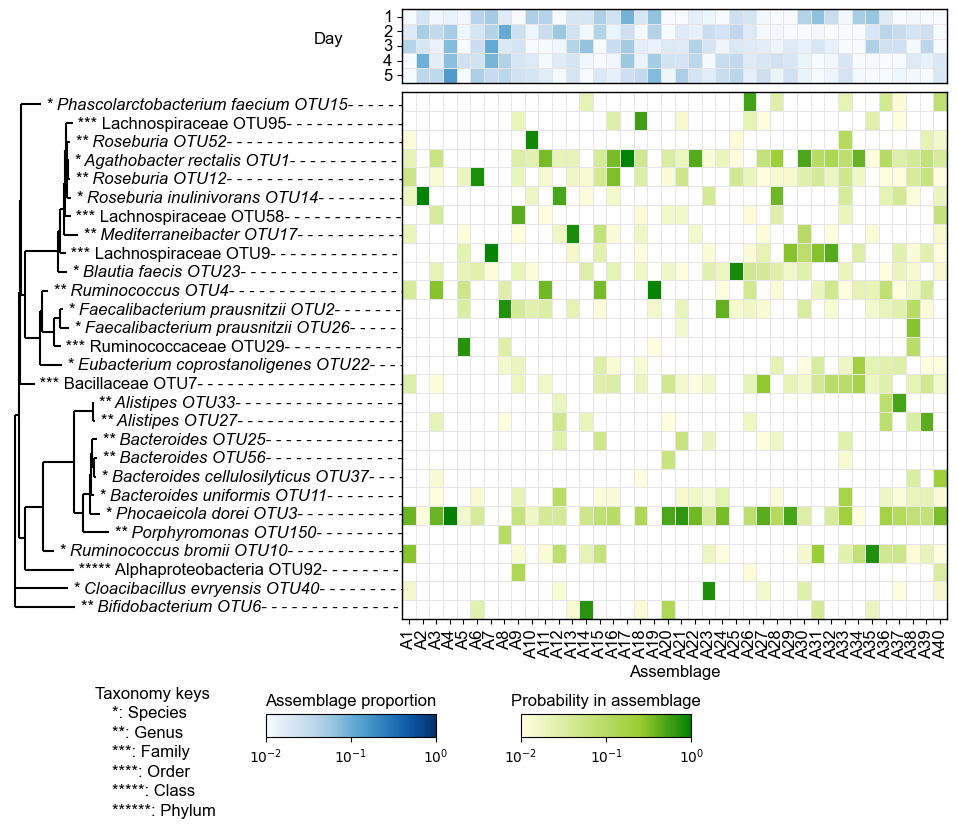

In [34]:
scale=2
fontsize = 12
subfontsize = 12
tree_text_len = 50

# set aspect ratios
# add buffers so scales always same?
hratios = [1.6*ntime/notu_max, notus/notu_max, lgd_gap, lgd_ratio]
hratios.append(1.0 - (nsubj*ntime/notu_max) - (notus/notu_max)) # buffer?
wratios = [tree_ratio, gap_ratio, ncomm/ncomm_max, 1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=1+2+2,ncols=4,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.1,
                     hspace=0.02)


# create subplots, get axes
ax_beta = fig.add_subplot(gs[0,2])
ax_tree = fig.add_subplot(gs[1,0])
# ax_theta = fig.add_subplot(gs[1,2])
# squish to center lines...
squish_ratio = 0.005
squish_hspace = 0
gs_theta = gs[1,2].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_theta = fig.add_subplot(gs_theta[1,0])

# for legend...
gs_lgd = gs[-2,:-1].subgridspec(3,4, wspace=0.5)
ax_taxa_lgd = fig.add_subplot(gs_lgd[:,0])
ax_beta_lgd = fig.add_subplot(gs_lgd[0,1])
ax_theta_lgd = fig.add_subplot(gs_lgd[0,2])

# plot assemlage proportions
# beta_order = get_abundance_order(betadf)

ax_beta = vis.plot_subject_proportions_timeseries(ax_beta, betadf, subj='H11', vmin=-2, order=beta_order)
ax_beta.set_xticks([])
ax_beta.set_yticklabels(ax_beta.get_yticklabels(), rotation=0, fontsize=subfontsize)
ax_beta.set_ylabel("Day", rotation=0, labelpad=50, ha='left', fontsize=fontsize)
ax_beta.set_xlabel("")
ax_beta = vis.add_border(ax_beta)

# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu").loc[otu_sub,:]
tree = vis.get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"), upper=True)

# plot tree
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize, text_len=tree_text_len)

# plot assemblages
ax_theta=vis.plot_assemblages(ax_theta, thetadf, otu_order, beta_order, cmap=theta_cmap, 
                          vmin=theta_vmin, vmax=theta_vmax) #, cmap=extended_cmap, vmin=-3) #'Greens')
ax_theta.set_xlabel("Assemblage", fontsize=fontsize)
ax_theta.set_ylabel("")
ax_theta.set_xticklabels(ax_theta.get_xticklabels(), rotation=90, fontsize=subfontsize)
ax_theta = vis.add_border(ax_theta)



# plot legend
norm = theta_norm #mpl.colors.Normalize(vmin=theta_vmin, vmax=theta_vmax)
ax_theta_lgd=mpl.colorbar.ColorbarBase(ax_theta_lgd, cmap=theta_cmap, norm=norm, orientation='horizontal')
ax_theta_lgd.ax.set_xticks([0,-1,-2])
ax_theta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_theta_lgd.ax.set_title("Probability in assemblage")

norm = mpl.colors.Normalize(vmin=-2, vmax=-0)
ax_beta_lgd=mpl.colorbar.ColorbarBase(ax_beta_lgd, cmap="Blues", norm=norm, orientation='horizontal')
ax_beta_lgd.ax.set_xticks([0,-1,-2])
ax_beta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_beta_lgd.ax.set_title("Assemblage proportion")


lgd_xpos=0.5
lgd_ypos=1.2
indent_xpos=lgd_xpos+0.1
dy=0.25
lgd_fontsize=12

levels = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', ] #'Kingdom']      
level_dict = {'Species': '*', 'Genus': '**', 'Family': '***',
              'Order': '****', 'Class': '*****', 'Phylum': '******'} #, 'Kingdom': '*******'}
    
ax_taxa_lgd.text(lgd_xpos,lgd_ypos,"Taxonomy keys", fontsize=lgd_fontsize)
for i,level in enumerate(levels):
    ax_taxa_lgd.text(indent_xpos, lgd_ypos - (i+1)*dy, f"{level_dict[level]}: {level}", fontsize=lgd_fontsize)
ax_taxa_lgd=vis.remove_border(ax_taxa_lgd)

plt.savefig(outpath / "figureS5_human_assemblages.svg", bbox_inches="tight")